In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 
%matplotlib inline
plt.style.use('fivethirtyeight')
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

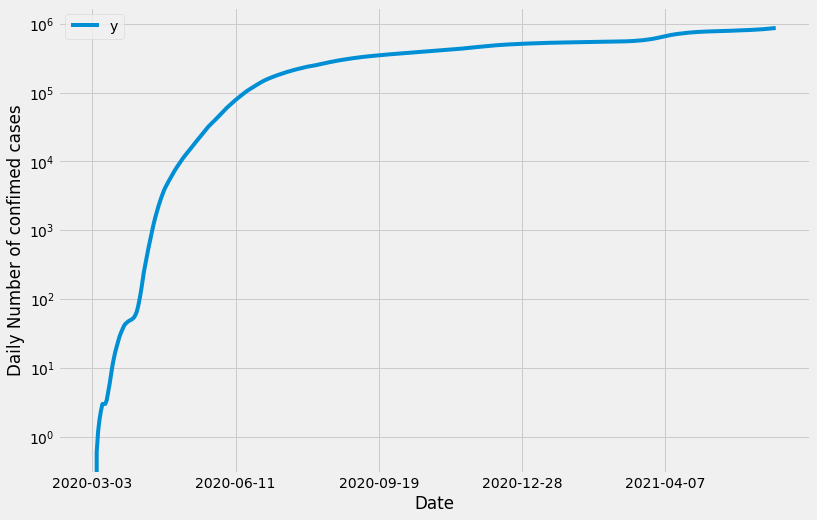

In [ ]:
df_all = pd.read_csv('/content/drive/MyDrive/New data/csv files/bd_owid_filtered.csv',sep=';')
df=df_all[['date','total_cases_filter']]
df=df.rename(columns={'date': 'ds',
                        'total_cases_filter': 'y'})
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [ ]:

my_model = Prophet(growth='logistic')   # logistic model
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)



INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=10, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
483,2021-06-29,1000000.0
484,2021-06-30,1000000.0
485,2021-07-01,1000000.0
486,2021-07-02,1000000.0
487,2021-07-03,1000000.0


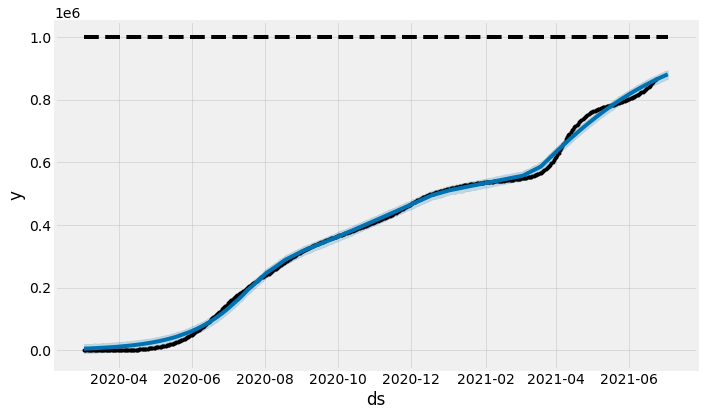

In [ ]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [ ]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,6])
py.iplot(fig)

In [ ]:
forecast.sort_values(by='ds').tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
483,2021-06-29,873816.908138,1000000.0,858821.333561,888329.800557,873719.563161,874021.958880,-49.589295,-49.589295,-49.589295,-49.589295,-49.589295,-49.589295,0.0,0.0,0.0,873767.318843
484,2021-06-30,875524.692956,1000000.0,860417.368625,890619.245554,875355.175550,875842.388142,84.653549,84.653549,84.653549,84.653549,84.653549,84.653549,0.0,0.0,0.0,875609.346505
485,2021-07-01,877212.612174,1000000.0,863353.260615,892505.413397,876955.352123,877610.022296,74.884872,74.884872,74.884872,74.884872,74.884872,74.884872,0.0,0.0,0.0,877287.497046
486,2021-07-02,878880.809137,1000000.0,863594.600522,892398.825353,878509.591771,879386.859734,36.332803,36.332803,36.332803,36.332803,36.332803,36.332803,0.0,0.0,0.0,878917.141941
487,2021-07-03,880529.428593,1000000.0,865261.261552,894302.220841,880035.081931,881191.661381,-25.697538,-25.697538,-25.697538,-25.697538,-25.697538,-25.697538,0.0,0.0,0.0,880503.731055


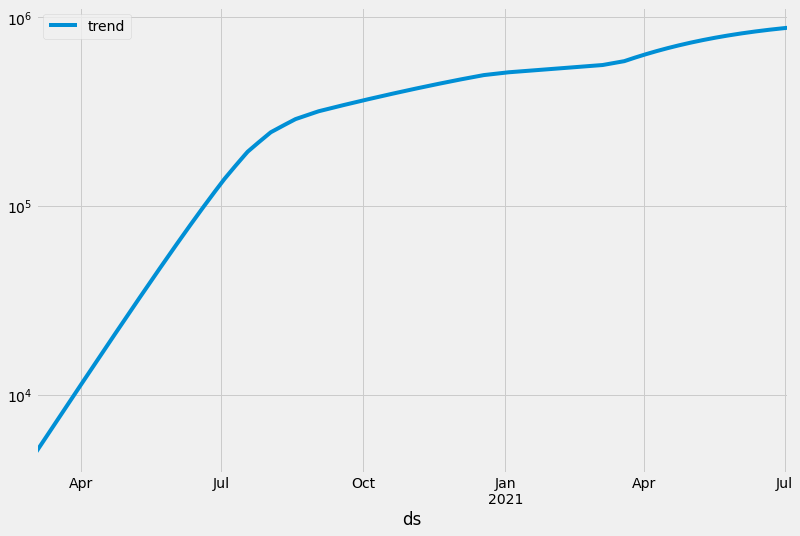

In [ ]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

In [ ]:
#cross validation

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 40 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future
                         

INFO:fbprophet:Making 431 forecasts with cutoffs between 2020-04-12 00:00:00 and 2021-06-16 00:00:00


In [ ]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.tail()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
3012,2021-06-19,852886.871418,836803.535551,868604.369888,848411.2,2021-06-16
3013,2021-06-20,854698.591468,840123.024642,871055.953002,852423.8,2021-06-16
3014,2021-06-21,856525.550136,840986.865688,872000.684962,856805.2,2021-06-16
3015,2021-06-22,858331.881964,843649.076809,873455.660892,861523.4,2021-06-16
3016,2021-06-23,860239.589780,844934.210014,875707.773796,866241.6,2021-06-16


In [ ]:
df1=df_cv[['ds','yhat']]
df1.tail()

,ds,yhat
3012,2021-06-19,852886.871418
3013,2021-06-20,854698.591468
3014,2021-06-21,856525.550136
3015,2021-06-22,858331.881964
3016,2021-06-23,860239.589780


In [ ]:
fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,6])
py.iplot(fig)

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,5.823514e+08,24131.957922,12701.484054,0.036271,0.019833,0.136891
1,2 days,6.261707e+08,25023.402266,13498.992226,0.042508,0.022405,0.129930
2,3 days,6.726690e+08,25935.863846,14324.013998,0.049454,0.024934,0.129930
3,4 days,7.220096e+08,26870.236790,15176.215797,0.057121,0.027366,0.127610
4,5 days,7.744629e+08,27829.173513,16058.749035,0.065603,0.029467,0.127610
5,6 days,8.302988e+08,28814.905041,16993.986334,0.074933,0.031905,0.129930
6,7 days,8.897692e+08,29829.000069,17978.850530,0.085237,0.034135,0.141531
